# <span style="color:green"> Numerical Simulation Laboratory (NSL) </span>
## <span style="color:blue">  Numerical exercises 7</span>

### Exercise 07.1
In the NSL simulator code we have provided, include tail corrections for potential energy, $U$, and pressure $P$.

### Equilibration

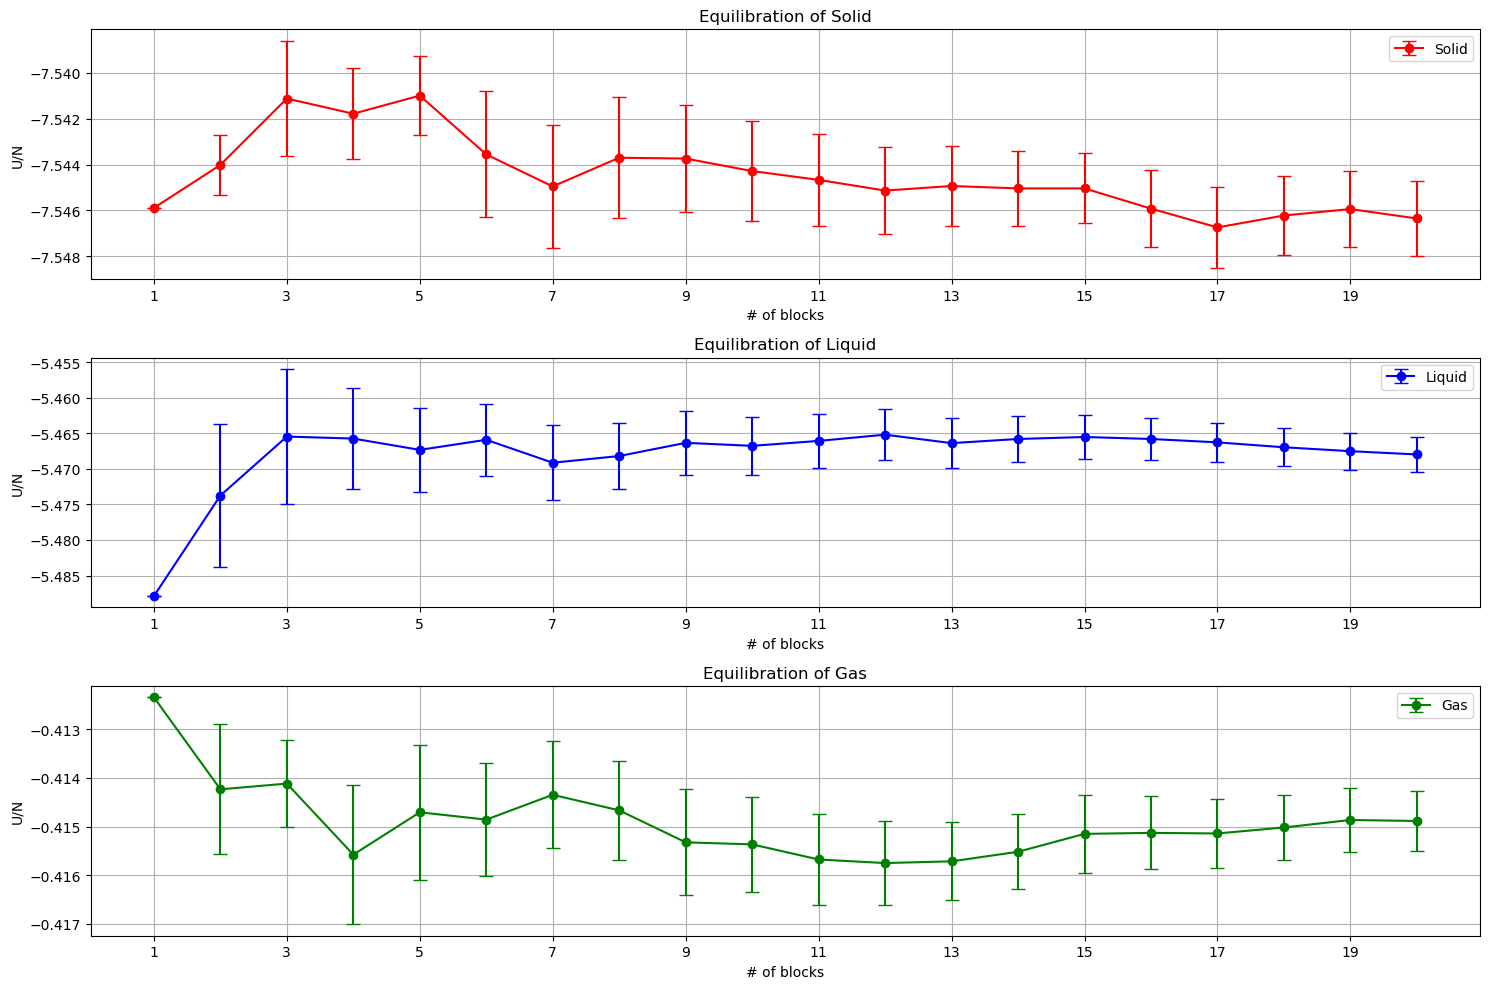

In [33]:
import pandas as pd
import matplotlib.pyplot as plt

# Funzione per leggere i dati e prepararli

def leggi_dati(file_path):
    # Leggi i dati dal file, usando lo spazio come delimitatore
    data = pd.read_csv(file_path, delim_whitespace=True)

    # Rimuovi l'intestazione se presente
    if '# BLOCK:' in data.columns[0]:
        data = data.iloc[1:].reset_index(drop=True)

    # Assegna i nomi delle colonne manualmente
    data.columns = ['BLOCK', 'ACTUAL_PE', 'PE_AVE', 'ERROR', 'EXTRA'] if data.shape[1] == 5 else ['BLOCK', 'ACTUAL_PE', 'PE_AVE', 'ERROR']

    # Converti le colonne in numerico
    data = data[['BLOCK', 'ACTUAL_PE', 'PE_AVE', 'ERROR']].apply(pd.to_numeric)

    return data

# Percorsi ai file dei dati
file_solid = 'Solid/OUTPUT_equilibration/OUTPUT/potential_energy.dat'
file_liquid = 'Liquid/OUTPUT_equilibration/OUTPUT/potential_energy.dat'
file_gas = 'Gas/OUTPUT_equilibration/OUTPUT/potential_energy.dat'

# Leggi i dati
solid_data = leggi_dati(file_solid)
liquid_data = leggi_dati(file_liquid)
gas_data = leggi_dati(file_gas)

# Estrai colonne per ciascun sistema
num_blocchi_solid, medie_blocchi_solid, errori_solid = solid_data['BLOCK'], solid_data['PE_AVE'], solid_data['ERROR']
num_blocchi_liquid, medie_blocchi_liquid, errori_liquid = liquid_data['BLOCK'], liquid_data['PE_AVE'], liquid_data['ERROR']
num_blocchi_gas, medie_blocchi_gas, errori_gas = gas_data['BLOCK'], gas_data['PE_AVE'], gas_data['ERROR']

# Crea i grafici
plt.figure(figsize=(15,10))

# Grafico Solid
plt.subplot(3, 1, 1)
plt.errorbar(num_blocchi_solid, medie_blocchi_solid, yerr=errori_solid, fmt='-o', capsize=5, color='r', label='Solid')
plt.xlabel('# of blocks')
plt.ylabel('U/N')
plt.title('Equilibration of Solid')
plt.legend()
plt.grid(True)
plt.xticks(ticks=num_blocchi_solid[::2], labels=num_blocchi_solid[::2])

# Grafico Liquid
plt.subplot(3, 1, 2)
plt.errorbar(num_blocchi_liquid, medie_blocchi_liquid, yerr=errori_liquid, fmt='-o', capsize=5, color='b', label='Liquid')
plt.xlabel('# of blocks')
plt.ylabel('U/N')
plt.title('Equilibration of Liquid')
plt.legend()
plt.grid(True)
plt.xticks(ticks=num_blocchi_liquid[::2], labels=num_blocchi_liquid[::2])

# Grafico Gas
plt.subplot(3, 1, 3)
plt.errorbar(num_blocchi_gas, medie_blocchi_gas, yerr=errori_gas, fmt='-o', capsize=5, color='g', label='Gas')
plt.xlabel('# of blocks')
plt.ylabel('U/N')
plt.title('Equilibration of Gas')
plt.legend()
plt.grid(True)
plt.xticks(ticks=num_blocchi_gas[::2], labels=num_blocchi_gas[::2])

# Mostra tutti i grafici
plt.tight_layout()
plt.show()


### Exercise 07.2

Use the NSL simulator code to <span style="color:red">print out instantaneous values of potential energy per particle, $U/N$, along **equilibrated** Monte Carlo simulations</span> (of $M=5\times 10^5$ MC steps and where the Metropolis acceptance ratio has been fixed approximately to 50%) in the following thermodynamic conditions:
- solid phase: $\rho^\star = 1.1$, $T^\star = 0.8$ (cut-off radius: $r_c = 2.2$)
- liquid phase: $\rho^\star = 0.8$, $T^\star = 1.1$ (cut-off radius: $r_c = 2.5$)
- gas phase: $\rho^\star = 0.05$, $T^\star = 1.2$ (cut-off radius: $r_c = 5.0$)

1. <span style="color:red">Once this data has been produced, compute and make pictures with a python script of the autocorrelation functions of $U/N$ to approximately estimate how large the blocks in your simulations should be.
2. Use the same data to study, with a python script, the estimation of the statistical uncertainties of the expectation value of $U/N$ for different size of the blocks in the data blocking technique, from $L=M/N=10$ to $L=5\times 10^3$, being $N$ the number of blocks. <span style="color:red">Make pictures of these statistical uncertainties as a function of $L$.</span> What you observe in the statistical uncertainties after that the block size is large enough (from the point of view of the data blocking technique)?

Loaded 100000 data points from 'Solid/OUTPUT/istant_pe.dat'
Computing autocorrelation function up to lag = 2000


Computing Autocorrelation: 100%|████████████| 2000/2000 [00:41<00:00, 47.76it/s]


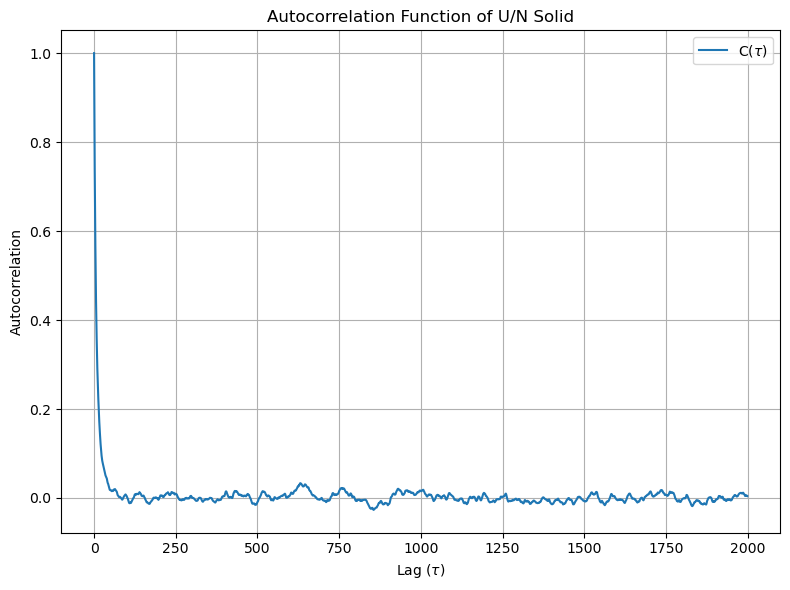

Saved autocorrelation plot to 'autocorr_U_per_particle.png'
L =    10:  Mean = -7.54906,  Error = 0.00073
L =    20:  Mean = -7.54906,  Error = 0.00089
L =    50:  Mean = -7.54906,  Error = 0.00105
L =   100:  Mean = -7.54906,  Error = 0.00114
L =   200:  Mean = -7.54906,  Error = 0.00119
L =   500:  Mean = -7.54906,  Error = 0.00124
L =  1000:  Mean = -7.54906,  Error = 0.00128
L =  2000:  Mean = -7.54906,  Error = 0.00122
L =  4000:  Mean = -7.54906,  Error = 0.00143
L =  5000:  Mean = -7.54906,  Error = 0.00121
L = 10000:  Mean = -7.54906,  Error = 0.00062


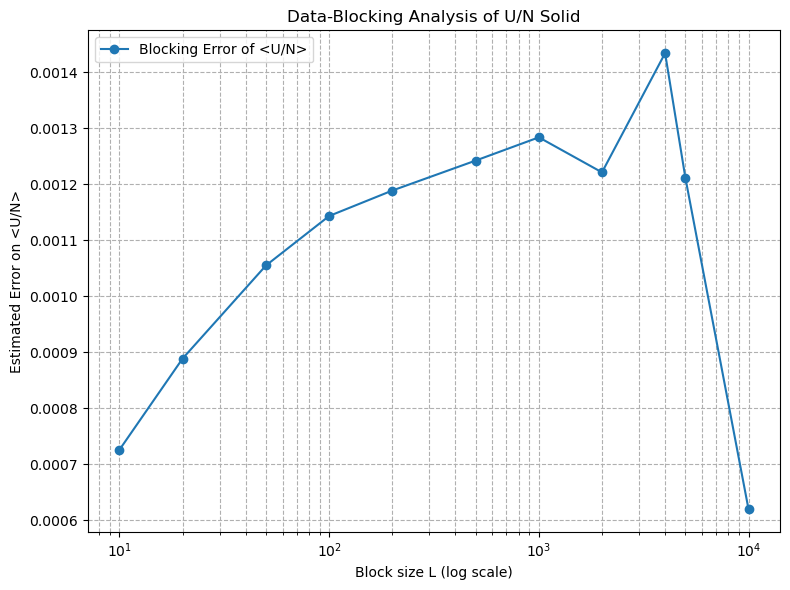

Saved data-blocking plot to 'blocking_error_U_per_particle.png'


In [34]:
#!/usr/bin/env python3
# --------------------------------------------------------------------
# Corrected Python script to compute:
#   1) Autocorrelation function of U/N
#   2) Statistical uncertainty via data blocking
# for a given time series of length M = 5e5 (or similar).
#
# Usage:
#   python analyze_U_per_particle.py
#
# Ensure you have:
#   instantU.dat         # The file with your instantaneous U/N data
# --------------------------------------------------------------------
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm  # Optional: for progress bar

def autocorrelation(data, max_lag):
    """
    Compute the normalized autocorrelation function C(tau)
    up to lag = max_lag. Returns an array C of length max_lag,
    where:
        C[tau] = <(x_t - mean)*(x_{t+tau} - mean)> / <(x_t - mean)^2>
    """
    M = len(data)
    mean = np.mean(data)
    var  = np.var(data, ddof=0)  # population variance

    C = np.zeros(max_lag)
    for tau in tqdm(range(max_lag), desc="Computing Autocorrelation"):
        sum_corr = 0.0
        for t in range(M - tau):
            sum_corr += (data[t] - mean)*(data[t + tau] - mean)
        C[tau] = sum_corr / ((M - tau)*var)

    return C

def block_analysis(data, L):
    """
    Perform data-blocking analysis for a single block size L.
    Returns:
        mean_block    = average of the block means
        error_block   = estimate of the statistical error on mean_block
    """
    M = len(data)
    # Number of blocks
    N = M // L  # integer division
    if N == 0:
        raise ValueError(f"Block size L={L} is larger than the data size M={M}.")
    # Discard leftover if M % L != 0
    trimmed_data = data[:N*L]
    block_means = trimmed_data.reshape(N, L).mean(axis=1)

    mean_block = np.mean(block_means)
    # Sample variance among the block means
    var_block = np.var(block_means, ddof=1)
    # Standard error of the mean
    error_block = np.sqrt(var_block / N)

    return mean_block, error_block

def main():
    # ========= 1) LOAD DATA =====================================
    # Adjust filename/path as needed
    filename = "Solid/OUTPUT/istant_pe.dat"
    try:
        data = np.loadtxt(filename)
    except IOError:
        print(f"Error: File '{filename}' not found.")
        return
    M = len(data)
    print(f"Loaded {M} data points from '{filename}'")

    # ========= 2) AUTOCORRELATION ================================
    # Choose a maximum lag for the autocorrelation
    max_lag = 2000  # Adjust as needed, e.g., 2000
    if max_lag > M:
        print(f"Error: max_lag ({max_lag}) cannot exceed data size M ({M}).")
        return
    print("Computing autocorrelation function up to lag =", max_lag)
    C = autocorrelation(data, max_lag)

    # Plot the autocorrelation function
    plt.figure(figsize=(8,6))
    plt.plot(range(max_lag), C, label="C($\\tau$)")
    plt.xlabel("Lag ($\\tau$)")
    plt.ylabel("Autocorrelation")
    plt.title("Autocorrelation Function of U/N Solid")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.savefig("Solid/autocorr_U_per_particle.png", dpi=150)
    plt.show()
    plt.close()
    print("Saved autocorrelation plot to 'autocorr_U_per_particle.png'")

    # ========= 3) DATA BLOCKING ANALYSIS =========================
    # We'll try various block sizes L. 
    # Ensure each L divides M or handle it appropriately.
    L_array = [10, 20, 50, 100, 200, 500, 1000, 2000,4000, 5000,10000]
    means   = []
    errors  = []

    for L in L_array:
        try:
            mb, eb = block_analysis(data, L)
            means.append(mb)
            errors.append(eb)
            print(f"L = {L:5d}:  Mean = {mb:.5f},  Error = {eb:.5f}")
        except ValueError as ve:
            print(f"Skipping L={L}: {ve}")

    # Plot error vs block size
    plt.figure(figsize=(8,6))
    plt.plot(L_array, errors, 'o-', label="Blocking Error of <U/N>")
    plt.xscale('log')
    plt.xlabel("Block size L (log scale)")
    plt.ylabel("Estimated Error on <U/N>")
    plt.title("Data-Blocking Analysis of U/N Solid")
    plt.grid(True, which="both", ls="--")
    plt.legend()
    plt.tight_layout()
    plt.savefig("Solid/blocking_error_U_per_particle.png", dpi=150)
    plt.show()
    plt.close()
    print("Saved data-blocking plot to 'blocking_error_U_per_particle.png'")

if __name__ == "__main__":
    main()


Loaded 50000 data points from 'Liquid/OUTPUT/istant_pe.dat'
Computing autocorrelation function up to lag = 2000


Computing Autocorrelation: 100%|████████████| 2000/2000 [00:20<00:00, 95.59it/s]


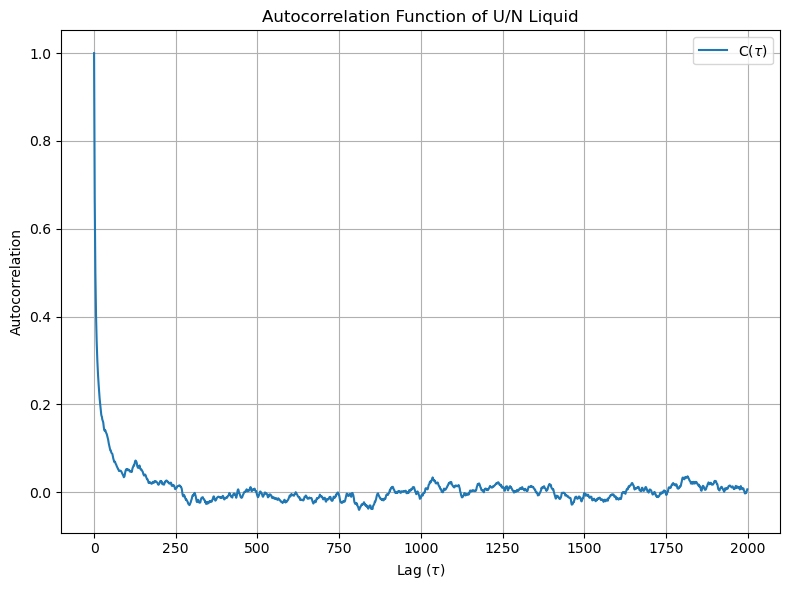

Saved autocorrelation plot to 'autocorr_U_per_particle.png'
L =    10:  Mean = -5.46301,  Error = 0.00109
L =    20:  Mean = -5.46301,  Error = 0.00135
L =    50:  Mean = -5.46301,  Error = 0.00177
L =   100:  Mean = -5.46301,  Error = 0.00206
L =   200:  Mean = -5.46301,  Error = 0.00238
L =   500:  Mean = -5.46301,  Error = 0.00259
L =  1000:  Mean = -5.46301,  Error = 0.00240
L =  2000:  Mean = -5.46301,  Error = 0.00212
L =  4000:  Mean = -5.46277,  Error = 0.00256
L =  5000:  Mean = -5.46301,  Error = 0.00281
L = 10000:  Mean = -5.46301,  Error = 0.00355


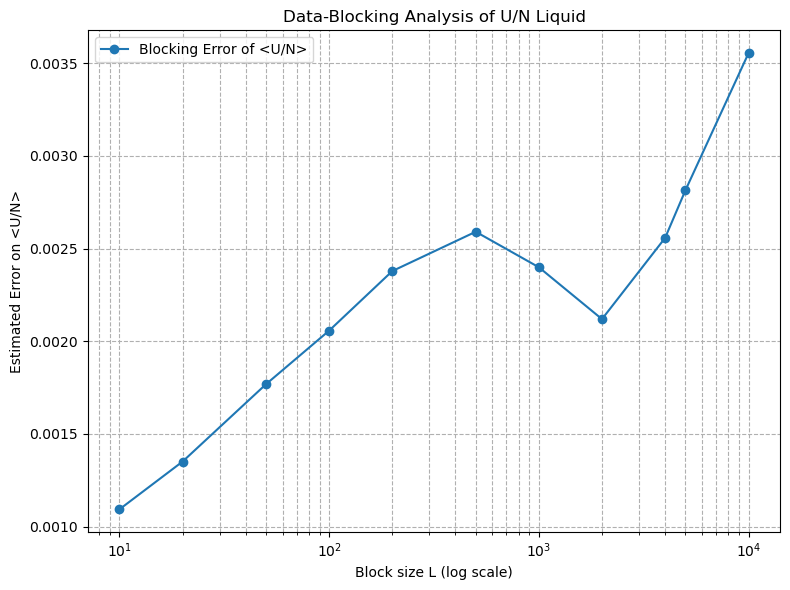

Saved data-blocking plot to 'blocking_error_U_per_particle.png'


In [35]:
#!/usr/bin/env python3
# --------------------------------------------------------------------
# Corrected Python script to compute:
#   1) Autocorrelation function of U/N
#   2) Statistical uncertainty via data blocking
# for a given time series of length M = 5e5 (or similar).
#
# Usage:
#   python analyze_U_per_particle.py
#
# Ensure you have:
#   instantU.dat         # The file with your instantaneous U/N data
# --------------------------------------------------------------------
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm  # Optional: for progress bar

def autocorrelation(data, max_lag):
    """
    Compute the normalized autocorrelation function C(tau)
    up to lag = max_lag. Returns an array C of length max_lag,
    where:
        C[tau] = <(x_t - mean)*(x_{t+tau} - mean)> / <(x_t - mean)^2>
    """
    M = len(data)
    mean = np.mean(data)
    var  = np.var(data, ddof=0)  # population variance

    C = np.zeros(max_lag)
    for tau in tqdm(range(max_lag), desc="Computing Autocorrelation"):
        sum_corr = 0.0
        for t in range(M - tau):
            sum_corr += (data[t] - mean)*(data[t + tau] - mean)
        C[tau] = sum_corr / ((M - tau)*var)

    return C

def block_analysis(data, L):
    """
    Perform data-blocking analysis for a single block size L.
    Returns:
        mean_block    = average of the block means
        error_block   = estimate of the statistical error on mean_block
    """
    M = len(data)
    # Number of blocks
    N = M // L  # integer division
    if N == 0:
        raise ValueError(f"Block size L={L} is larger than the data size M={M}.")
    # Discard leftover if M % L != 0
    trimmed_data = data[:N*L]
    block_means = trimmed_data.reshape(N, L).mean(axis=1)

    mean_block = np.mean(block_means)
    # Sample variance among the block means
    var_block = np.var(block_means, ddof=1)
    # Standard error of the mean
    error_block = np.sqrt(var_block / N)

    return mean_block, error_block

def main():
    # ========= 1) LOAD DATA =====================================
    # Adjust filename/path as needed
    filename = "Liquid/OUTPUT/istant_pe.dat"
    try:
        data = np.loadtxt(filename)
    except IOError:
        print(f"Error: File '{filename}' not found.")
        return
    M = len(data)
    print(f"Loaded {M} data points from '{filename}'")

    # ========= 2) AUTOCORRELATION ================================
    # Choose a maximum lag for the autocorrelation
    max_lag = 2000  # Adjust as needed, e.g., 2000
    if max_lag > M:
        print(f"Error: max_lag ({max_lag}) cannot exceed data size M ({M}).")
        return
    print("Computing autocorrelation function up to lag =", max_lag)
    C = autocorrelation(data, max_lag)

    # Plot the autocorrelation function
    plt.figure(figsize=(8,6))
    plt.plot(range(max_lag), C, label="C($\\tau$)")
    plt.xlabel("Lag ($\\tau$)")
    plt.ylabel("Autocorrelation")
    plt.title("Autocorrelation Function of U/N Liquid")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.savefig("Liquid/autocorr_U_per_particle.png", dpi=150)
    plt.show()
    plt.close()
    print("Saved autocorrelation plot to 'autocorr_U_per_particle.png'")

    # ========= 3) DATA BLOCKING ANALYSIS =========================
    # We'll try various block sizes L. 
    # Ensure each L divides M or handle it appropriately.
    L_array = [10, 20, 50, 100, 200, 500, 1000, 2000, 4000, 5000, 10000]
    means   = []
    errors  = []

    for L in L_array:
        try:
            mb, eb = block_analysis(data, L)
            means.append(mb)
            errors.append(eb)
            print(f"L = {L:5d}:  Mean = {mb:.5f},  Error = {eb:.5f}")
        except ValueError as ve:
            print(f"Skipping L={L}: {ve}")

    # Plot error vs block size
    plt.figure(figsize=(8,6))
    plt.plot(L_array, errors, 'o-', label="Blocking Error of <U/N>")
    plt.xscale('log')
    plt.xlabel("Block size L (log scale)")
    plt.ylabel("Estimated Error on <U/N>")
    plt.title("Data-Blocking Analysis of U/N Liquid")
    plt.grid(True, which="both", ls="--")
    plt.legend()
    plt.tight_layout()
    plt.savefig("Liquid/blocking_error_U_per_particle.png", dpi=150)
    plt.show()
    plt.close()
    print("Saved data-blocking plot to 'blocking_error_U_per_particle.png'")

if __name__ == "__main__":
    main()


Loaded 100000 data points from 'Gas/OUTPUT/istant_pe.dat'
Computing autocorrelation function up to lag = 4000


Computing Autocorrelation: 100%|████████████| 4000/4000 [01:23<00:00, 48.11it/s]


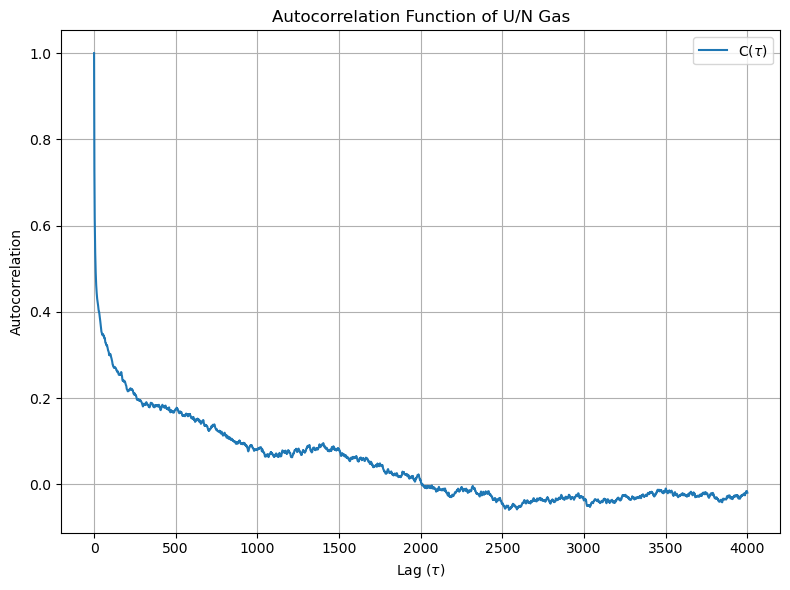

Saved autocorrelation plot to 'autocorr_U_per_particle.png'
L =    10:  Mean = -0.41409,  Error = 0.00044
L =    20:  Mean = -0.41409,  Error = 0.00058
L =    50:  Mean = -0.41409,  Error = 0.00084
L =   100:  Mean = -0.41409,  Error = 0.00111
L =   200:  Mean = -0.41409,  Error = 0.00145
L =   500:  Mean = -0.41409,  Error = 0.00202
L =  1000:  Mean = -0.41409,  Error = 0.00252
L =  2000:  Mean = -0.41409,  Error = 0.00285
L =  4000:  Mean = -0.41409,  Error = 0.00305
L =  5000:  Mean = -0.41409,  Error = 0.00381
L =  7000:  Mean = -0.41413,  Error = 0.00328
L = 10000:  Mean = -0.41409,  Error = 0.00150


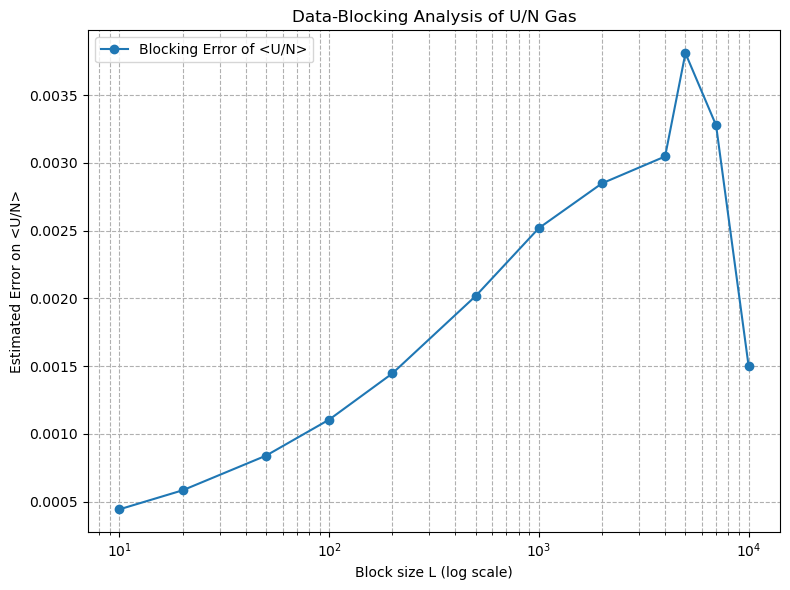

Saved data-blocking plot to 'blocking_error_U_per_particle.png'


In [36]:
#!/usr/bin/env python3
# --------------------------------------------------------------------
# Corrected Python script to compute:
#   1) Autocorrelation function of U/N
#   2) Statistical uncertainty via data blocking
# for a given time series of length M = 5e5 (or similar).
#
# Usage:
#   python analyze_U_per_particle.py
#
# Ensure you have:
#   instantU.dat         # The file with your instantaneous U/N data
# --------------------------------------------------------------------
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm  # Optional: for progress bar

def autocorrelation(data, max_lag):
    """
    Compute the normalized autocorrelation function C(tau)
    up to lag = max_lag. Returns an array C of length max_lag,
    where:
        C[tau] = <(x_t - mean)*(x_{t+tau} - mean)> / <(x_t - mean)^2>
    """
    M = len(data)
    mean = np.mean(data)
    var  = np.var(data, ddof=0)  # population variance

    C = np.zeros(max_lag)
    for tau in tqdm(range(max_lag), desc="Computing Autocorrelation"):
        sum_corr = 0.0
        for t in range(M - tau):
            sum_corr += (data[t] - mean)*(data[t + tau] - mean)
        C[tau] = sum_corr / ((M - tau)*var)

    return C

def block_analysis(data, L):
    """
    Perform data-blocking analysis for a single block size L.
    Returns:
        mean_block    = average of the block means
        error_block   = estimate of the statistical error on mean_block
    """
    M = len(data)
    # Number of blocks
    N = M // L  # integer division
    if N == 0:
        raise ValueError(f"Block size L={L} is larger than the data size M={M}.")
    # Discard leftover if M % L != 0
    trimmed_data = data[:N*L]
    block_means = trimmed_data.reshape(N, L).mean(axis=1)

    mean_block = np.mean(block_means)
    # Sample variance among the block means
    var_block = np.var(block_means, ddof=1)
    # Standard error of the mean
    error_block = np.sqrt(var_block / N)

    return mean_block, error_block

def main():
    # ========= 1) LOAD DATA =====================================
    # Adjust filename/path as needed
    filename = "Gas/OUTPUT/istant_pe.dat"
    try:
        data = np.loadtxt(filename)
    except IOError:
        print(f"Error: File '{filename}' not found.")
        return
    M = len(data)
    print(f"Loaded {M} data points from '{filename}'")

    # ========= 2) AUTOCORRELATION ================================
    # Choose a maximum lag for the autocorrelation
    max_lag = 4000  # Adjust as needed, e.g., 2000
    if max_lag > M:
        print(f"Error: max_lag ({max_lag}) cannot exceed data size M ({M}).")
        return
    print("Computing autocorrelation function up to lag =", max_lag)
    C = autocorrelation(data, max_lag)

    # Plot the autocorrelation function
    plt.figure(figsize=(8,6))
    plt.plot(range(max_lag), C, label="C($\\tau$)")
    plt.xlabel("Lag ($\\tau$)")
    plt.ylabel("Autocorrelation")
    plt.title("Autocorrelation Function of U/N Gas")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.savefig("Gas/autocorr_U_per_particle.png", dpi=150)
    plt.show()
    plt.close()
    print("Saved autocorrelation plot to 'autocorr_U_per_particle.png'")

    # ========= 3) DATA BLOCKING ANALYSIS =========================
    # We'll try various block sizes L. 
    # Ensure each L divides M or handle it appropriately.
    L_array = [10, 20, 50, 100, 200, 500, 1000, 2000, 4000, 5000, 7000, 10000]
    means   = []
    errors  = []

    for L in L_array:
        try:
            mb, eb = block_analysis(data, L)
            means.append(mb)
            errors.append(eb)
            print(f"L = {L:5d}:  Mean = {mb:.5f},  Error = {eb:.5f}")
        except ValueError as ve:
            print(f"Skipping L={L}: {ve}")

    # Plot error vs block size
    plt.figure(figsize=(8,6))
    plt.plot(L_array, errors, 'o-', label="Blocking Error of <U/N>")
    plt.xscale('log')
    plt.xlabel("Block size L (log scale)")
    plt.ylabel("Estimated Error on <U/N>")
    plt.title("Data-Blocking Analysis of U/N Gas")
    plt.grid(True, which="both", ls="--")
    plt.legend()
    plt.tight_layout()
    plt.savefig("Gas/blocking_error_U_per_particle.png", dpi=150)
    plt.show()
    plt.close()
    print("Saved data-blocking plot to 'blocking_error_U_per_particle.png'")

if __name__ == "__main__":
    main()


### Exercise 07.3

<span style="color:red">Include the calculation of the radial distribution function, $g(r)$, as a function of the radial distance $r$ among particles, with $r \in \left[ 0; L/2\right]$ inside the NSL simulator code</span>: average value of $g(r)$ in each block, final average value of $g(r)$ with statistical uncertainties in a separate file.

### Exercise 07.4

By means of your upgraded NSL simulator code, equilibrate and <span style="color:red">perform MC NVT simulations via a Lennard-Jones model</span> of Argon ($\sigma = 0.34$ nm, $\epsilon/k_B = 120$ K, $m=39.948$ amu) in the following conditions:
1. solid phase: $\rho^\star = 1.1$, $T^\star = 0.8$ (cut-off radius: $r_c = 2.2$)
2. liquid phase: $\rho^\star = 0.8$, $T^\star = 1.1$ (cut-off radius: $r_c = 2.5$)
3. gas phase: $\rho^\star = 0.05$, $T^\star = 1.2$ (cut-off radius: $r_c = 5.0$)

show in pictures the obtained average values and uncertainties for the potential energy per particle, $U/N$, the pressure $P$ and the radial distribution function $g(r)$ in LJ units ... <span style="color:red"> and compare your MC results for the radial distribution function, $g(r)$, with those obtained with Molecular Dynamics NVE simulations in similar thermodynamic conditions.</span>

### <span style="color:red"> Solid </span>

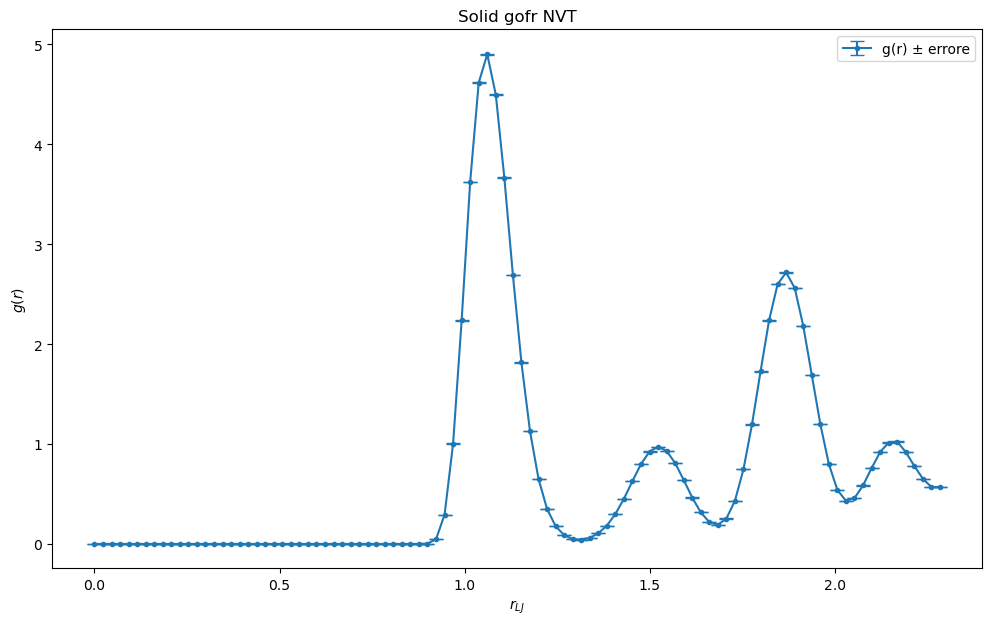

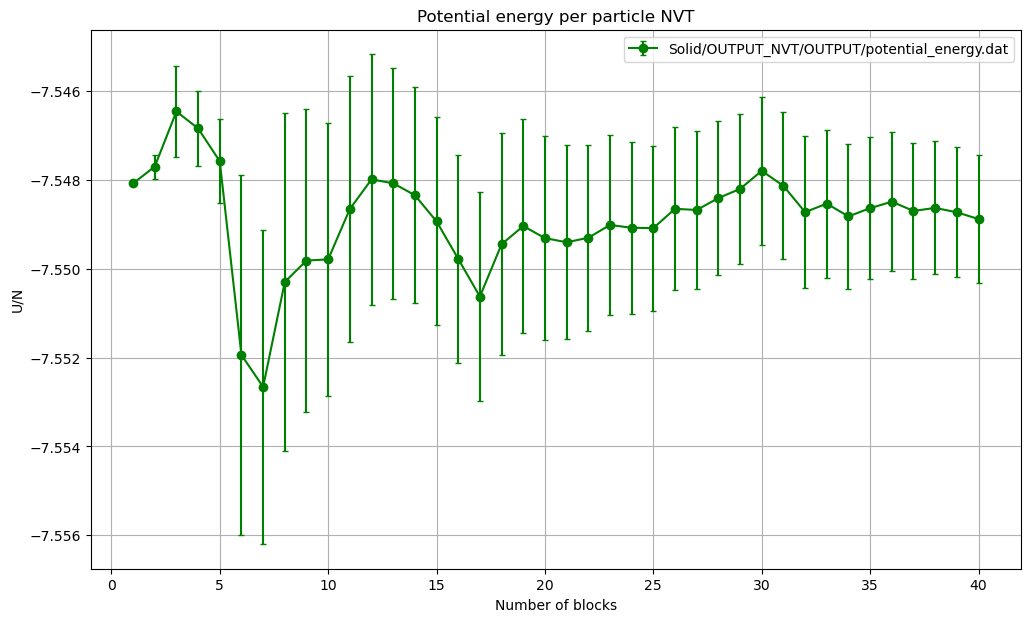

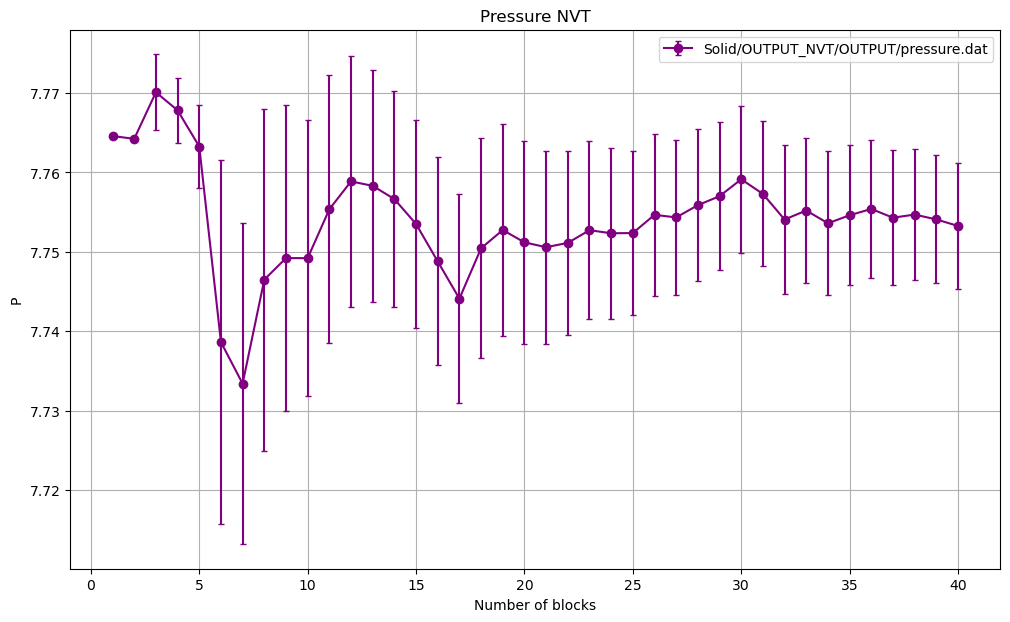

In [45]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import MultipleLocator

# Leggi i dati dal file
filename = 'Solid/OUTPUT_NVT/OUTPUT/gofr.dat'
data = np.loadtxt(filename)

# Estrai le colonne
distanza = data[:, 0]
valori = data[:, 1]
errore = data[:, 2]

# Crea il grafico
plt.figure(figsize=(12,7))
plt.errorbar(distanza, valori, yerr=errore, fmt='-o',markersize=3, capsize=5, label='g(r) ± errore')

# Aggiungi titolo e etichette
plt.title('Solid gofr NVT')
plt.xlabel('$r_{LJ}$')
plt.ylabel('$g(r)$')

# Mostra la legenda
plt.legend()

# Mostra il grafico
plt.show()

# P and U/N
def leggi_file(nome_file):
    # Inizializza le liste per memorizzare i dati
    num_blocchi = []
    media_blocchi = []
    media_totale = []
    errore = []

    # Apre il file e legge i dati
    with open(nome_file, 'r') as file:
        # Ignora l'intestazione
        next(file)
        for riga in file:
            valori = riga.strip().split()
            num_blocchi.append(int(valori[0]))
            media_blocchi.append(float(valori[1]))
            media_totale.append(float(valori[2]))
            errore.append(float(valori[3]))

    return num_blocchi, media_blocchi, media_totale, errore
    
def crea_grafico(nome_file, num_blocchi, media_totale, errore, colore, titolo, titolo_y):
    plt.figure(figsize=(12,7))
    plt.errorbar(num_blocchi, media_totale, yerr=errore, fmt='o-', label=nome_file, color=colore, capsize = 2)
    plt.xlabel('Number of blocks')
    plt.ylabel(titolo_y)
    plt.title(titolo)
    plt.xticks(num_blocchi)
    plt.gca().xaxis.set_major_locator(MultipleLocator(5))  # Imposta le etichette ogni 5 punti sull'asse x
    plt.legend()
    plt.grid(True)
    plt.show()

def main():
    # Elenco dei nomi dei file, dei colori e dei titoli
    file_info = [
        ('Solid/OUTPUT_NVT/OUTPUT/potential_energy.dat', 'green', 'Potential energy per particle NVT', 'U/N'),
        ('Solid/OUTPUT_NVT/OUTPUT/pressure.dat', 'purple', 'Pressure NVT', 'P')]
    for file_name, colore, titolo, titolo_y in file_info:
       # Legge i dati dal file
        num_blocchi, _, media_totale, errore = leggi_file(file_name)

        # Crea il grafico
        crea_grafico(file_name, num_blocchi, media_totale, errore, colore, titolo, titolo_y)

if __name__ == "__main__":
    main()


Dati NVT caricati da 'Solid/OUTPUT_NVT/OUTPUT/gofr.dat'
Dati NVE caricati da '../lez4/Solid/OUTPUT/gofr.dat'
Grafico salvato come 'Solid/gofr_comparison_NVT_NVE.png'


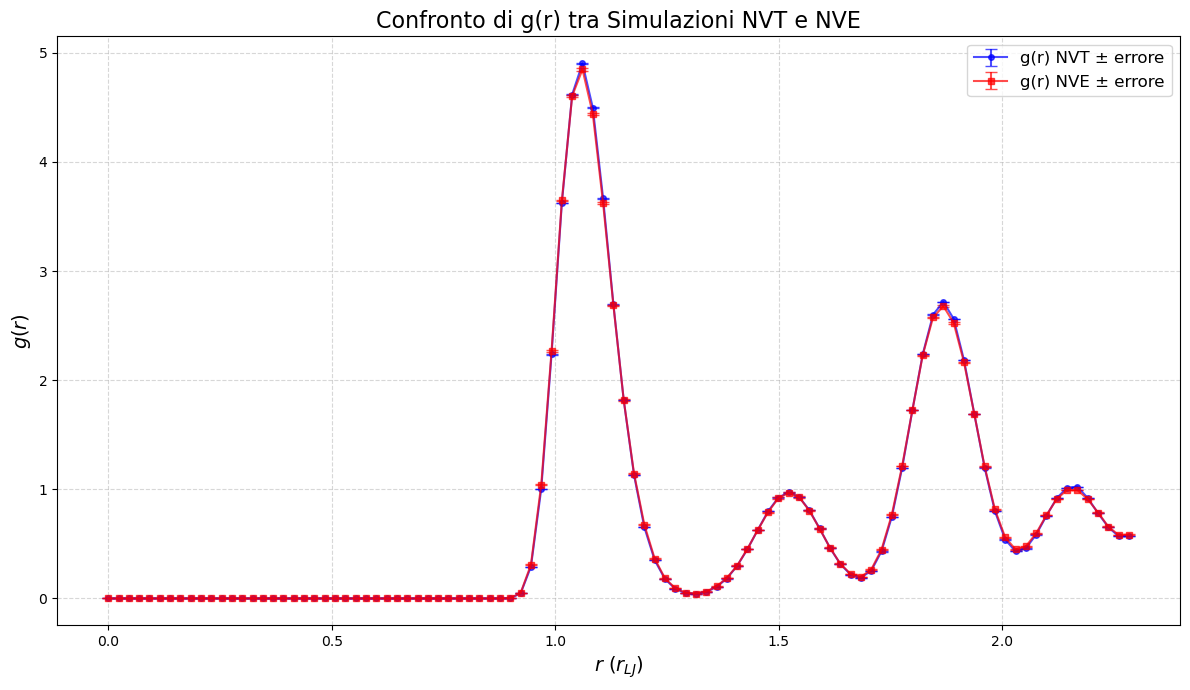

In [46]:
import numpy as np
import matplotlib.pyplot as plt
import os

def load_gofr(filename):
    """
    Carica i dati g(r) da un file.

    Parametri:
        filename (str): Percorso al file di dati g(r).

    Ritorna:
        tuple: (distanza, valori_gofr, errore_gofr)
    """
    if not os.path.isfile(filename):
        raise FileNotFoundError(f"File non trovato: {filename}")
    
    data = np.loadtxt(filename)
    if data.shape[1] < 3:
        raise ValueError(f"Il file {filename} deve contenere almeno tre colonne.")
    
    distanza = data[:, 0]
    valori = data[:, 1]
    errore = data[:, 2]
    return distanza, valori, errore

def plot_gofr(distanza_NVT, valori_NVT, errore_NVT, distanza_NVE, valori_NVE, errore_NVE, output_filename='gofr_comparison.png'):
    """
    Traccia g(r) per NVT e NVE sullo stesso grafico con barre di errore.

    Parametri:
        distanza_NVT (array): Distanze per NVT.
        valori_NVT (array): Valori di g(r) per NVT.
        errore_NVT (array): Incertezze per NVT.
        distanza_NVE (array): Distanze per NVE.
        valori_NVE (array): Valori di g(r) per NVE.
        errore_NVE (array): Incertezze per NVE.
        output_filename (str): Nome del file immagine da salvare.
    """
    plt.figure(figsize=(12, 7))

    # Traccia g(r) per NVT
    plt.errorbar(distanza_NVT, valori_NVT, yerr=errore_NVT, fmt='-o',
                 markersize=4, capsize=4, label='g(r) NVT ± errore', color='blue', alpha=0.7)

    # Traccia g(r) per NVE
    plt.errorbar(distanza_NVE, valori_NVE, yerr=errore_NVE, fmt='-s',
                 markersize=4, capsize=4, label='g(r) NVE ± errore', color='red', alpha=0.7)

    # Aggiungi titolo e etichette
    plt.title('Confronto di g(r) tra Simulazioni NVT e NVE', fontsize=16)
    plt.xlabel('$r$ ($r_{LJ}$)', fontsize=14)
    plt.ylabel('$g(r)$', fontsize=14)

    # Aggiungi legenda
    plt.legend(fontsize=12)

    # Aggiungi griglia
    plt.grid(True, linestyle='--', alpha=0.5)

    # Imposta limiti sugli assi se necessario
    # plt.xlim(0, L/2)  # Sostituisci L con la lunghezza del lato del box se desiderato

    # Salva il grafico
    plt.tight_layout()
    plt.savefig(output_filename, dpi=300)
    print(f"Grafico salvato come '{output_filename}'")

    # Mostra il grafico
    plt.show()

def main():
    # Definisci i percorsi ai file g(r)
    filename_NVT = 'Solid/OUTPUT_NVT/OUTPUT/gofr.dat'
    filename_NVE = '../lez4/Solid/OUTPUT/gofr.dat'

    try:
        # Carica dati NVT
        distanza_NVT, valori_NVT, errore_NVT = load_gofr(filename_NVT)
        print(f"Dati NVT caricati da '{filename_NVT}'")
    except Exception as e:
        print(f"Errore nel caricamento dei dati NVT: {e}")
        return

    try:
        # Carica dati NVE
        distanza_NVE, valori_NVE, errore_NVE = load_gofr(filename_NVE)
        print(f"Dati NVE caricati da '{filename_NVE}'")
    except Exception as e:
        print(f"Errore nel caricamento dei dati NVE: {e}")
        return

    # Verifica che le distanze corrispondano
    if not np.array_equal(distanza_NVT, distanza_NVE):
        print("Avviso: le distanze nei file NVT e NVE non corrispondono. Potrebbe essere necessario allinearle.")
        # Puoi aggiungere codice qui per allineare le distanze se necessario

    # Traccia i grafici
    plot_gofr(distanza_NVT, valori_NVT, errore_NVT,
             distanza_NVE, valori_NVE, errore_NVE,
             output_filename='Solid/gofr_comparison_NVT_NVE.png')

if __name__ == "__main__":
    main()


### <span style="color:blue"> Liquid </span>

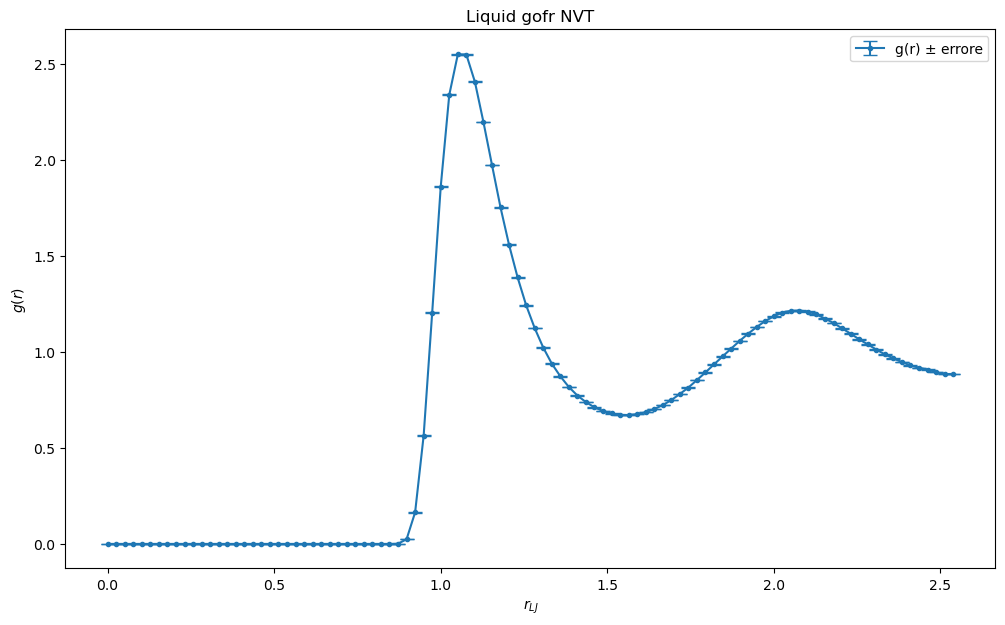

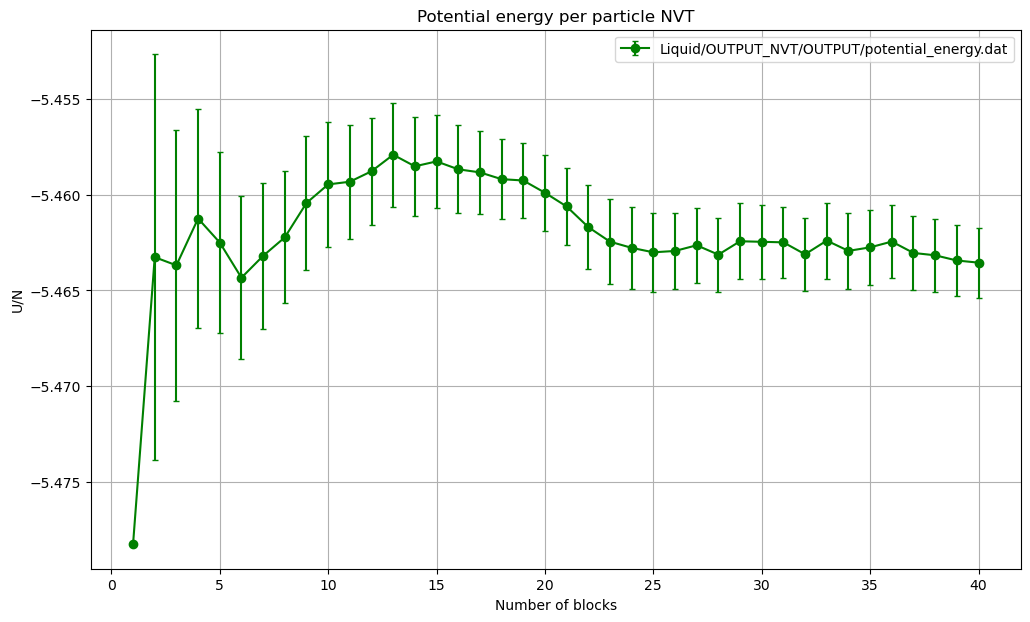

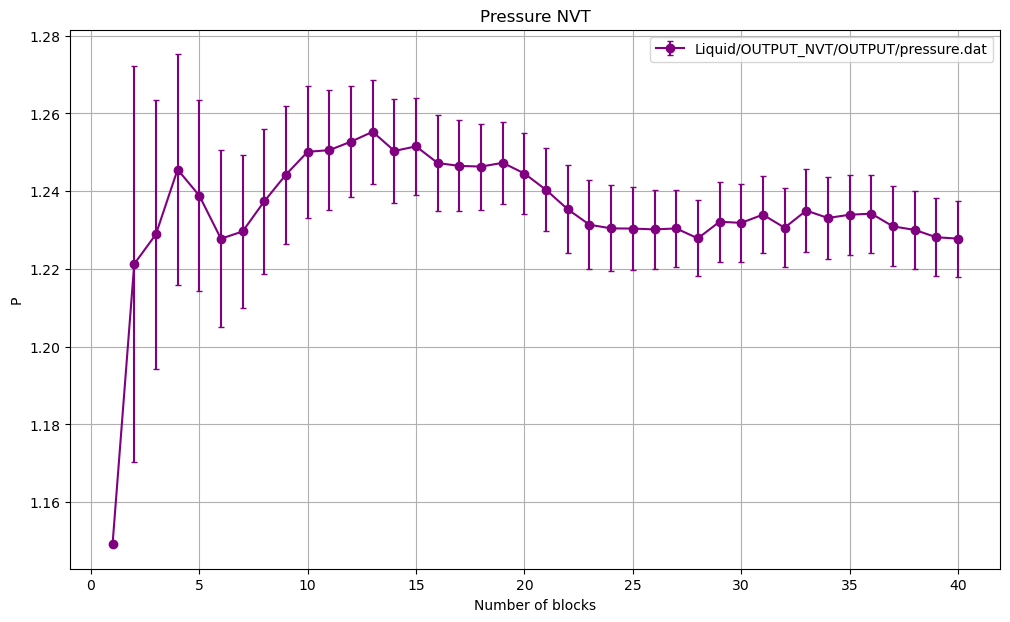

In [47]:
import numpy as np
import matplotlib.pyplot as plt

# Leggi i dati dal file
filename = 'Liquid/OUTPUT_NVT/OUTPUT/gofr.dat'
data = np.loadtxt(filename)

# Estrai le colonne
distanza = data[:, 0]
valori = data[:, 1]
errore = data[:, 2]

# Crea il grafico
plt.figure(figsize=(12,7))
plt.errorbar(distanza, valori, yerr=errore, fmt='-o',markersize=3, capsize=5, label='g(r) ± errore')

# Aggiungi titolo e etichette
plt.title('Liquid gofr NVT')
plt.xlabel('$r_{LJ}$')
plt.ylabel('$g(r)$')

# Mostra la legenda
plt.legend()

# Mostra il grafico
plt.show()

# P and U/N
def leggi_file(nome_file):
    # Inizializza le liste per memorizzare i dati
    num_blocchi = []
    media_blocchi = []
    media_totale = []
    errore = []

    # Apre il file e legge i dati
    with open(nome_file, 'r') as file:
        # Ignora l'intestazione
        next(file)
        for riga in file:
            valori = riga.strip().split()
            num_blocchi.append(int(valori[0]))
            media_blocchi.append(float(valori[1]))
            media_totale.append(float(valori[2]))
            errore.append(float(valori[3]))

    return num_blocchi, media_blocchi, media_totale, errore
    
def crea_grafico(nome_file, num_blocchi, media_totale, errore, colore, titolo, titolo_y):
    plt.figure(figsize=(12,7))
    plt.errorbar(num_blocchi, media_totale, yerr=errore, fmt='o-', label=nome_file, color=colore, capsize = 2)
    plt.xlabel('Number of blocks')
    plt.ylabel(titolo_y)
    plt.title(titolo)
    plt.xticks(num_blocchi)
    plt.gca().xaxis.set_major_locator(MultipleLocator(5))  # Imposta le etichette ogni 5 punti sull'asse x
    plt.legend()
    plt.grid(True)
    plt.show()

def main():
    # Elenco dei nomi dei file, dei colori e dei titoli
    file_info = [
        ('Liquid/OUTPUT_NVT/OUTPUT/potential_energy.dat', 'green', 'Potential energy per particle NVT', 'U/N'),
        ('Liquid/OUTPUT_NVT/OUTPUT/pressure.dat', 'purple', 'Pressure NVT', 'P')]
    for file_name, colore, titolo, titolo_y in file_info:
       # Legge i dati dal file
        num_blocchi, _, media_totale, errore = leggi_file(file_name)

        # Crea il grafico
        crea_grafico(file_name, num_blocchi, media_totale, errore, colore, titolo, titolo_y)

if __name__ == "__main__":
    main()


Dati NVT caricati da 'Liquid/OUTPUT_NVT/OUTPUT/gofr.dat'
Dati NVE caricati da '../lez4/Liquid/OUTPUT/gofr.dat'
Grafico salvato come 'Liquid/gofr_comparison_NVT_NVE.png'


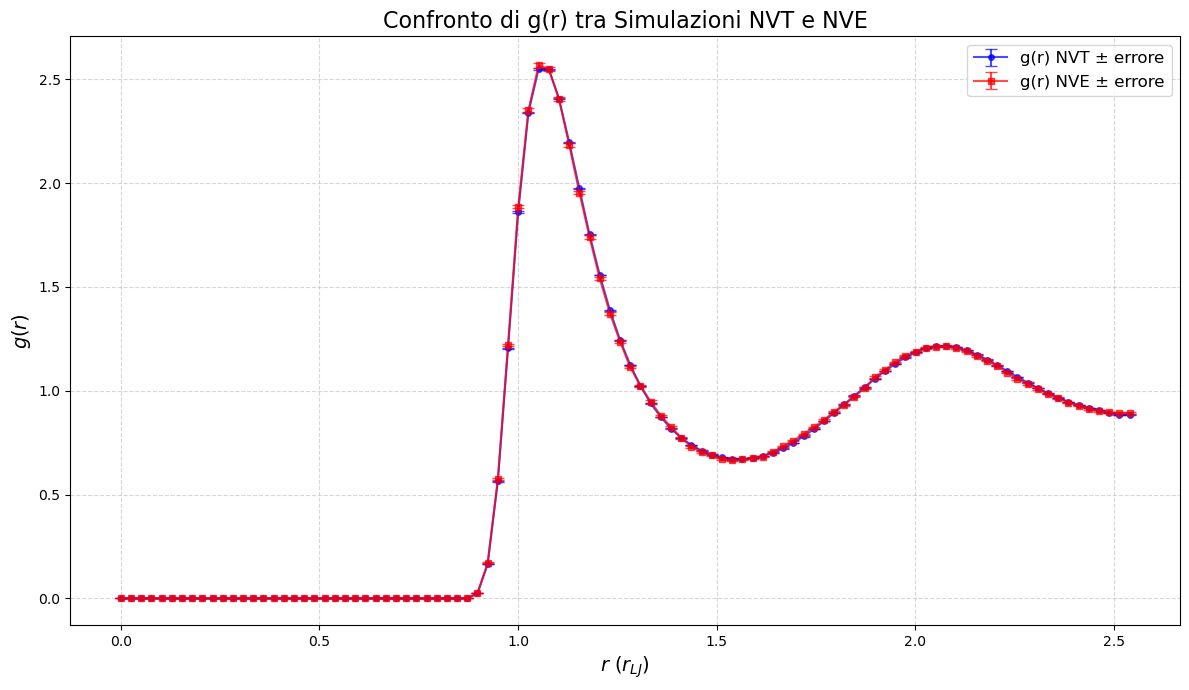

In [48]:
import numpy as np
import matplotlib.pyplot as plt
import os

def load_gofr(filename):
    """
    Carica i dati g(r) da un file.

    Parametri:
        filename (str): Percorso al file di dati g(r).

    Ritorna:
        tuple: (distanza, valori_gofr, errore_gofr)
    """
    if not os.path.isfile(filename):
        raise FileNotFoundError(f"File non trovato: {filename}")
    
    data = np.loadtxt(filename)
    if data.shape[1] < 3:
        raise ValueError(f"Il file {filename} deve contenere almeno tre colonne.")
    
    distanza = data[:, 0]
    valori = data[:, 1]
    errore = data[:, 2]
    return distanza, valori, errore

def plot_gofr(distanza_NVT, valori_NVT, errore_NVT, distanza_NVE, valori_NVE, errore_NVE, output_filename='gofr_comparison.png'):
    """
    Traccia g(r) per NVT e NVE sullo stesso grafico con barre di errore.

    Parametri:
        distanza_NVT (array): Distanze per NVT.
        valori_NVT (array): Valori di g(r) per NVT.
        errore_NVT (array): Incertezze per NVT.
        distanza_NVE (array): Distanze per NVE.
        valori_NVE (array): Valori di g(r) per NVE.
        errore_NVE (array): Incertezze per NVE.
        output_filename (str): Nome del file immagine da salvare.
    """
    plt.figure(figsize=(12, 7))

    # Traccia g(r) per NVT
    plt.errorbar(distanza_NVT, valori_NVT, yerr=errore_NVT, fmt='-o',
                 markersize=4, capsize=4, label='g(r) NVT ± errore', color='blue', alpha=0.7)

    # Traccia g(r) per NVE
    plt.errorbar(distanza_NVE, valori_NVE, yerr=errore_NVE, fmt='-s',
                 markersize=4, capsize=4, label='g(r) NVE ± errore', color='red', alpha=0.7)

    # Aggiungi titolo e etichette
    plt.title('Confronto di g(r) tra Simulazioni NVT e NVE', fontsize=16)
    plt.xlabel('$r$ ($r_{LJ}$)', fontsize=14)
    plt.ylabel('$g(r)$', fontsize=14)

    # Aggiungi legenda
    plt.legend(fontsize=12)

    # Aggiungi griglia
    plt.grid(True, linestyle='--', alpha=0.5)

    # Imposta limiti sugli assi se necessario
    # plt.xlim(0, L/2)  # Sostituisci L con la lunghezza del lato del box se desiderato

    # Salva il grafico
    plt.tight_layout()
    plt.savefig(output_filename, dpi=300)
    print(f"Grafico salvato come '{output_filename}'")

    # Mostra il grafico
    plt.show()

def main():
    # Definisci i percorsi ai file g(r)
    filename_NVT = 'Liquid/OUTPUT_NVT/OUTPUT/gofr.dat'
    filename_NVE = '../lez4/Liquid/OUTPUT/gofr.dat'

    try:
        # Carica dati NVT
        distanza_NVT, valori_NVT, errore_NVT = load_gofr(filename_NVT)
        print(f"Dati NVT caricati da '{filename_NVT}'")
    except Exception as e:
        print(f"Errore nel caricamento dei dati NVT: {e}")
        return

    try:
        # Carica dati NVE
        distanza_NVE, valori_NVE, errore_NVE = load_gofr(filename_NVE)
        print(f"Dati NVE caricati da '{filename_NVE}'")
    except Exception as e:
        print(f"Errore nel caricamento dei dati NVE: {e}")
        return

    # Verifica che le distanze corrispondano
    if not np.array_equal(distanza_NVT, distanza_NVE):
        print("Avviso: le distanze nei file NVT e NVE non corrispondono. Potrebbe essere necessario allinearle.")
        # Puoi aggiungere codice qui per allineare le distanze se necessario

    # Traccia i grafici
    plot_gofr(distanza_NVT, valori_NVT, errore_NVT,
             distanza_NVE, valori_NVE, errore_NVE,
             output_filename='Liquid/gofr_comparison_NVT_NVE.png')

if __name__ == "__main__":
    main()


### <span style="color:green"> Gas </span>

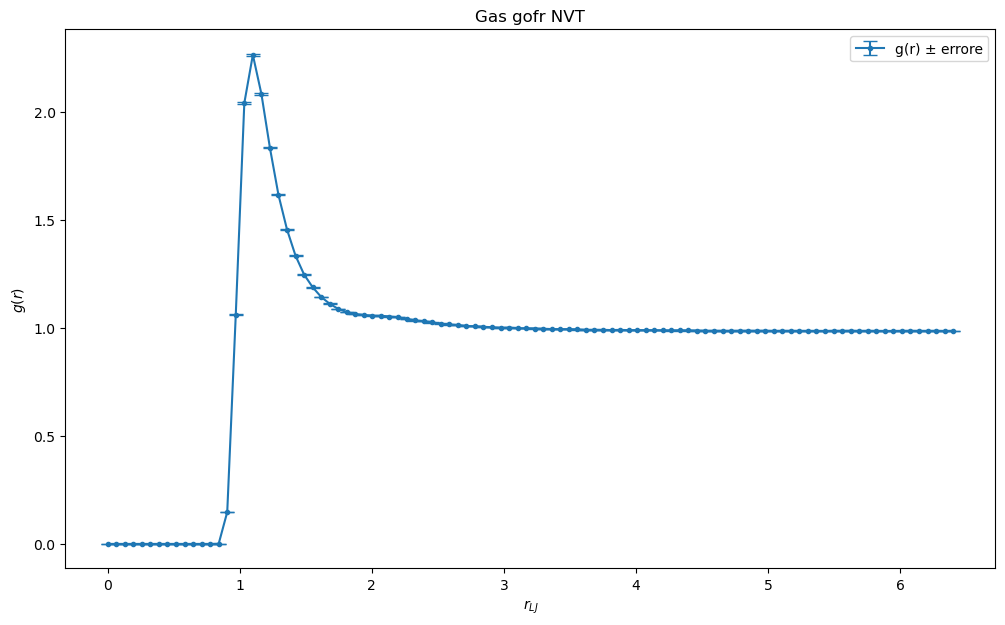

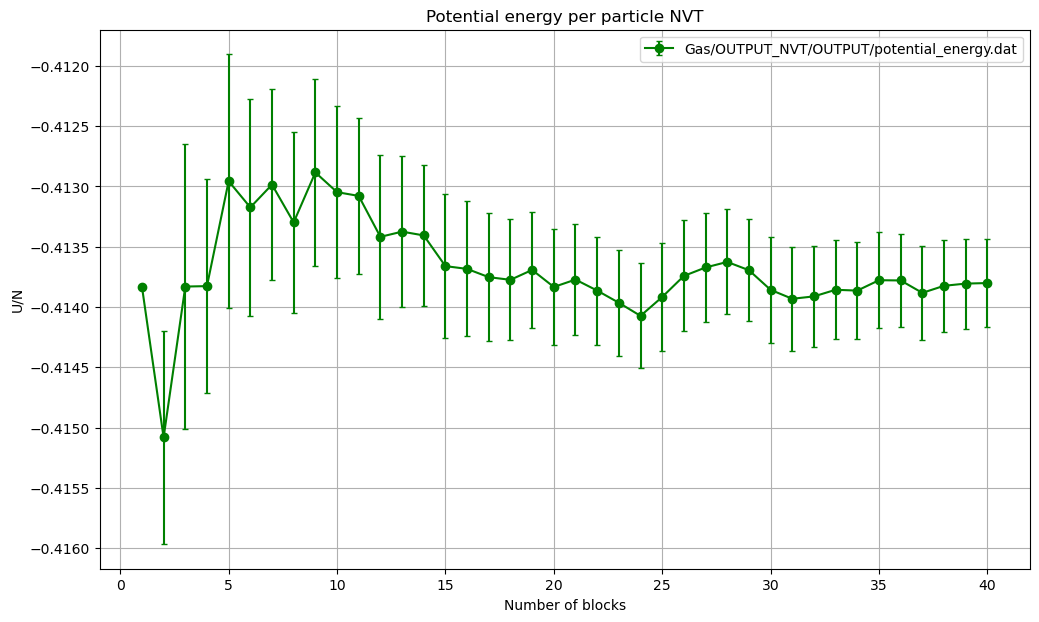

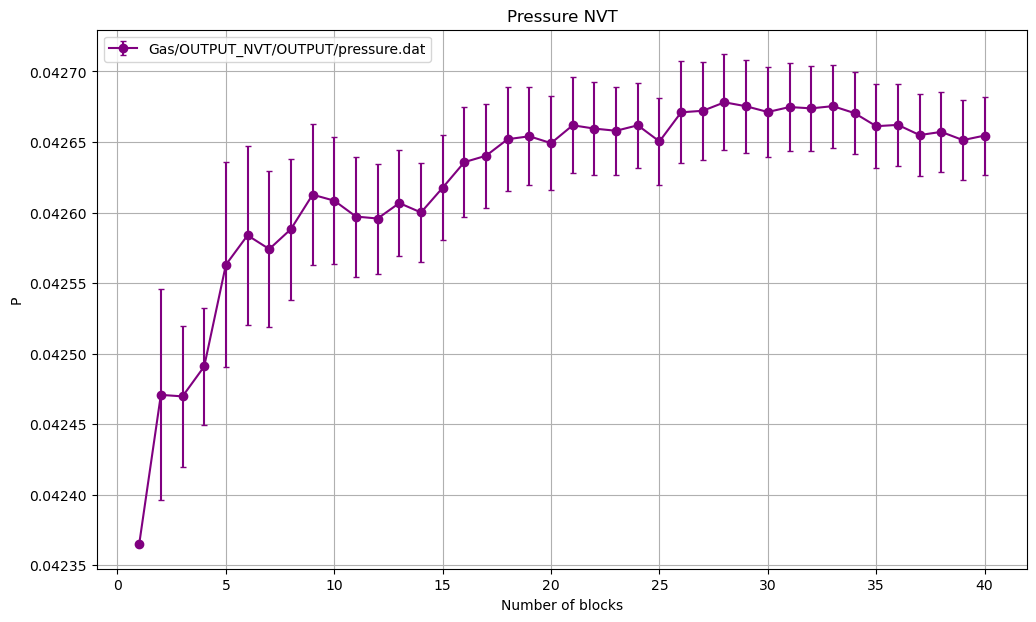

In [49]:
import numpy as np
import matplotlib.pyplot as plt

# Leggi i dati dal file
filename = 'Gas/OUTPUT_NVT/OUTPUT/gofr.dat'
data = np.loadtxt(filename)

# Estrai le colonne
distanza = data[:, 0]
valori = data[:, 1]
errore = data[:, 2]

# Crea il grafico
plt.figure(figsize=(12,7))
plt.errorbar(distanza, valori, yerr=errore, fmt='-o',markersize=3, capsize=5, label='g(r) ± errore')

# Aggiungi titolo e etichette
plt.title('Gas gofr NVT')
plt.xlabel('$r_{LJ}$')
plt.ylabel('$g(r)$')

# Mostra la legenda
plt.legend()

# Mostra il grafico
plt.show()

# P and U/N
def leggi_file(nome_file):
    # Inizializza le liste per memorizzare i dati
    num_blocchi = []
    media_blocchi = []
    media_totale = []
    errore = []

    # Apre il file e legge i dati
    with open(nome_file, 'r') as file:
        # Ignora l'intestazione
        next(file)
        for riga in file:
            valori = riga.strip().split()
            num_blocchi.append(int(valori[0]))
            media_blocchi.append(float(valori[1]))
            media_totale.append(float(valori[2]))
            errore.append(float(valori[3]))

    return num_blocchi, media_blocchi, media_totale, errore
    
def crea_grafico(nome_file, num_blocchi, media_totale, errore, colore, titolo, titolo_y):
    plt.figure(figsize=(12,7))
    plt.errorbar(num_blocchi, media_totale, yerr=errore, fmt='o-', label=nome_file, color=colore, capsize = 2)
    plt.xlabel('Number of blocks')
    plt.ylabel(titolo_y)
    plt.title(titolo)
    plt.xticks(num_blocchi)
    plt.gca().xaxis.set_major_locator(MultipleLocator(5))  # Imposta le etichette ogni 5 punti sull'asse x
    plt.legend()
    plt.grid(True)
    plt.show()

def main():
    # Elenco dei nomi dei file, dei colori e dei titoli
    file_info = [
        ('Gas/OUTPUT_NVT/OUTPUT/potential_energy.dat', 'green', 'Potential energy per particle NVT', 'U/N'),
        ('Gas/OUTPUT_NVT/OUTPUT/pressure.dat', 'purple', 'Pressure NVT', 'P')]
    for file_name, colore, titolo, titolo_y in file_info:
       # Legge i dati dal file
        num_blocchi, _, media_totale, errore = leggi_file(file_name)

        # Crea il grafico
        crea_grafico(file_name, num_blocchi, media_totale, errore, colore, titolo, titolo_y)

if __name__ == "__main__":
    main()


Dati NVT caricati da 'Gas/OUTPUT_NVT/OUTPUT/gofr.dat'
Dati NVE caricati da '../lez4/Gas/OUTPUT/gofr.dat'
Grafico salvato come 'Gas/gofr_comparison_NVT_NVE.png'


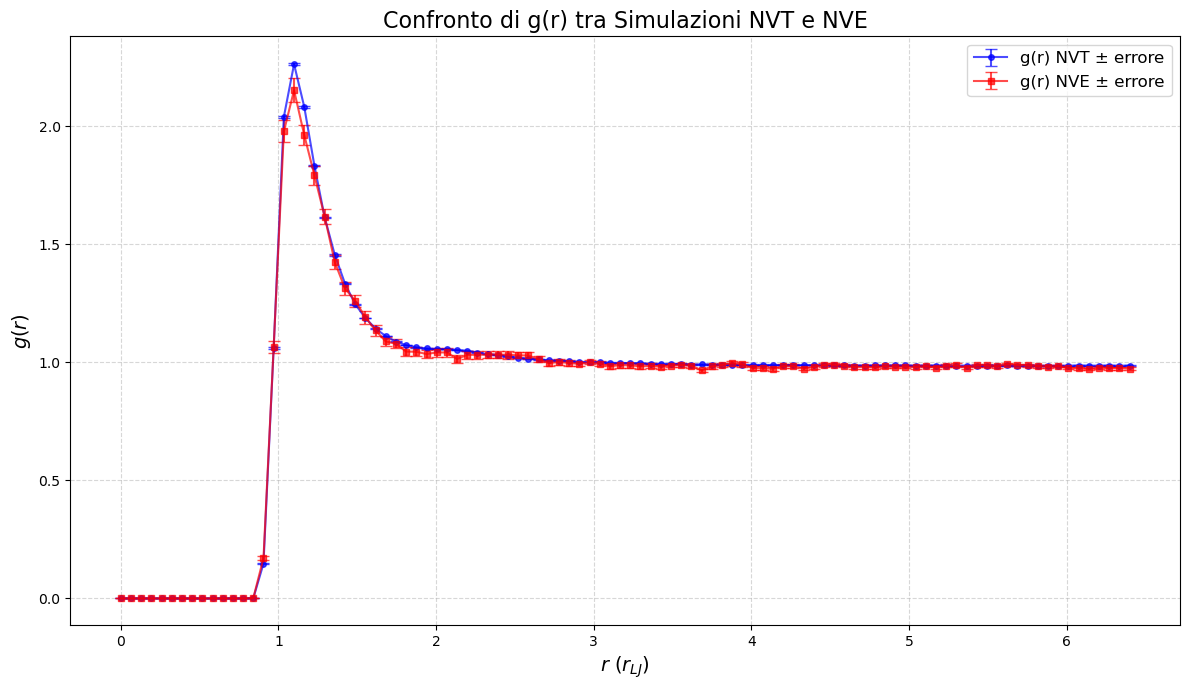

In [50]:
import numpy as np
import matplotlib.pyplot as plt
import os

def load_gofr(filename):
    """
    Carica i dati g(r) da un file.

    Parametri:
        filename (str): Percorso al file di dati g(r).

    Ritorna:
        tuple: (distanza, valori_gofr, errore_gofr)
    """
    if not os.path.isfile(filename):
        raise FileNotFoundError(f"File non trovato: {filename}")
    
    data = np.loadtxt(filename)
    if data.shape[1] < 3:
        raise ValueError(f"Il file {filename} deve contenere almeno tre colonne.")
    
    distanza = data[:, 0]
    valori = data[:, 1]
    errore = data[:, 2]
    return distanza, valori, errore

def plot_gofr(distanza_NVT, valori_NVT, errore_NVT, distanza_NVE, valori_NVE, errore_NVE, output_filename='gofr_comparison.png'):
    """
    Traccia g(r) per NVT e NVE sullo stesso grafico con barre di errore.

    Parametri:
        distanza_NVT (array): Distanze per NVT.
        valori_NVT (array): Valori di g(r) per NVT.
        errore_NVT (array): Incertezze per NVT.
        distanza_NVE (array): Distanze per NVE.
        valori_NVE (array): Valori di g(r) per NVE.
        errore_NVE (array): Incertezze per NVE.
        output_filename (str): Nome del file immagine da salvare.
    """
    plt.figure(figsize=(12, 7))

    # Traccia g(r) per NVT
    plt.errorbar(distanza_NVT, valori_NVT, yerr=errore_NVT, fmt='-o',
                 markersize=4, capsize=4, label='g(r) NVT ± errore', color='blue', alpha=0.7)

    # Traccia g(r) per NVE
    plt.errorbar(distanza_NVE, valori_NVE, yerr=errore_NVE, fmt='-s',
                 markersize=4, capsize=4, label='g(r) NVE ± errore', color='red', alpha=0.7)

    # Aggiungi titolo e etichette
    plt.title('Confronto di g(r) tra Simulazioni NVT e NVE', fontsize=16)
    plt.xlabel('$r$ ($r_{LJ}$)', fontsize=14)
    plt.ylabel('$g(r)$', fontsize=14)

    # Aggiungi legenda
    plt.legend(fontsize=12)

    # Aggiungi griglia
    plt.grid(True, linestyle='--', alpha=0.5)

    # Imposta limiti sugli assi se necessario
    # plt.xlim(0, L/2)  # Sostituisci L con la lunghezza del lato del box se desiderato

    # Salva il grafico
    plt.tight_layout()
    plt.savefig(output_filename, dpi=300)
    print(f"Grafico salvato come '{output_filename}'")

    # Mostra il grafico
    plt.show()

def main():
    # Definisci i percorsi ai file g(r)
    filename_NVT = 'Gas/OUTPUT_NVT/OUTPUT/gofr.dat'
    filename_NVE = '../lez4/Gas/OUTPUT/gofr.dat'

    try:
        # Carica dati NVT
        distanza_NVT, valori_NVT, errore_NVT = load_gofr(filename_NVT)
        print(f"Dati NVT caricati da '{filename_NVT}'")
    except Exception as e:
        print(f"Errore nel caricamento dei dati NVT: {e}")
        return

    try:
        # Carica dati NVE
        distanza_NVE, valori_NVE, errore_NVE = load_gofr(filename_NVE)
        print(f"Dati NVE caricati da '{filename_NVE}'")
    except Exception as e:
        print(f"Errore nel caricamento dei dati NVE: {e}")
        return

    # Verifica che le distanze corrispondano
    if not np.array_equal(distanza_NVT, distanza_NVE):
        print("Avviso: le distanze nei file NVT e NVE non corrispondono. Potrebbe essere necessario allinearle.")
        # Puoi aggiungere codice qui per allineare le distanze se necessario

    # Traccia i grafici
    plot_gofr(distanza_NVT, valori_NVT, errore_NVT,
             distanza_NVE, valori_NVE, errore_NVE,
             output_filename='Gas/gofr_comparison_NVT_NVE.png')

if __name__ == "__main__":
    main()
